# 👖 Fashion MNIST 上的自编码器

在本节中，我们将逐步介绍在 Fashion MNIST 数据集上训练你自己的自编码器

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

## 0. Parameters <a name="parameters"></a>

In [23]:
# Parameters
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
EMBEDDING_DIM = 2
EPOCHS = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## 1. 数据加载 & 预处理 <a name="prepare"></a>

In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),        # [0,255] → [0,1], shape: [1,28,28]
    transforms.Pad(2),             # 28×28 → 32×32
])

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 2. Build the autoencoder <a name="build"></a>

In [25]:
class Encoder(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 32×16×16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 64×8×8
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),# 128×4×4
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 4 * 4, embedding_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        z = self.fc(x)
        return z

In [26]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.fc = nn.Linear(embedding_dim, 128 * 4 * 4)

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid(),  # 对应 binary_crossentropy
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 4, 4)
        x = self.deconv(x)
        return x

In [27]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.encoder = Encoder(embedding_dim)
        self.decoder = Decoder(embedding_dim)

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon

In [28]:
model = Autoencoder(EMBEDDING_DIM).to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 3. Train the autoencoder <a name="train"></a>

In [29]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, _ in train_loader:
        x = x.to(DEVICE)

        recon = model(x)
        loss = criterion(recon, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/3] Loss: 0.2901
Epoch [2/3] Loss: 0.2568
Epoch [3/3] Loss: 0.2530


## 4. Reconstruct images <a name="reconstruct"></a>

Original


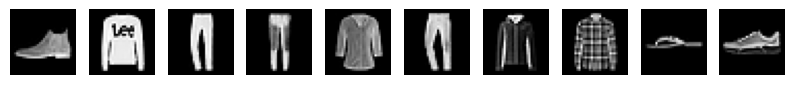

Reconstruction


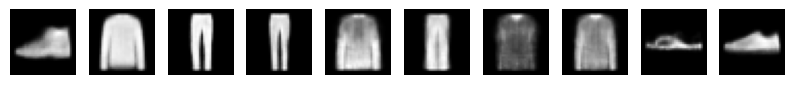

In [30]:
model.eval()

x, _ = next(iter(test_loader))
x = x.to(DEVICE)

with torch.no_grad():
    recon = model(x)

x = x.cpu().numpy()
recon = recon.cpu().numpy()

def show(images, n=10):
    plt.figure(figsize=(10,2))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(images[i,0], cmap="gray")
        plt.axis("off")
    plt.show()

print("Original")
show(x)

print("Reconstruction")
show(recon)

## 5. Embed using encoder <a name="reconstruct"></a>

In [40]:
embeddings = []
labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        z = model.encoder(x)
        embeddings.append(z.cpu())
        labels.append(y)

embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()

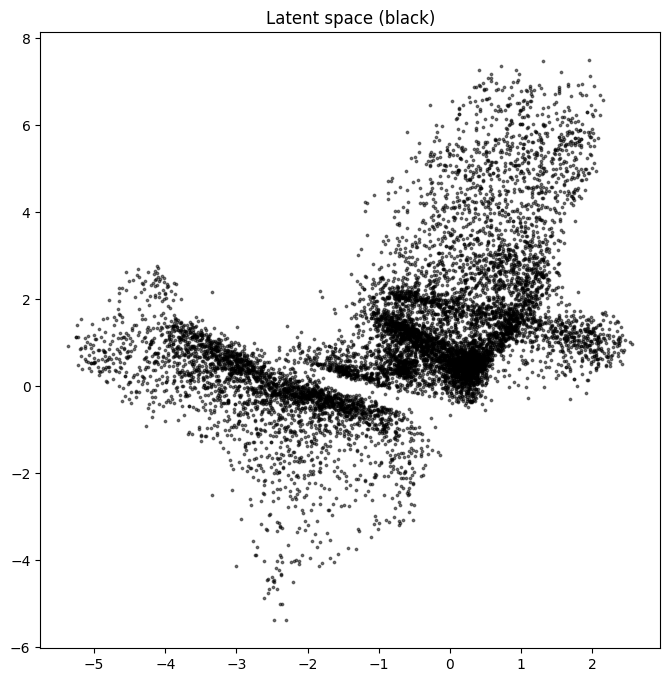

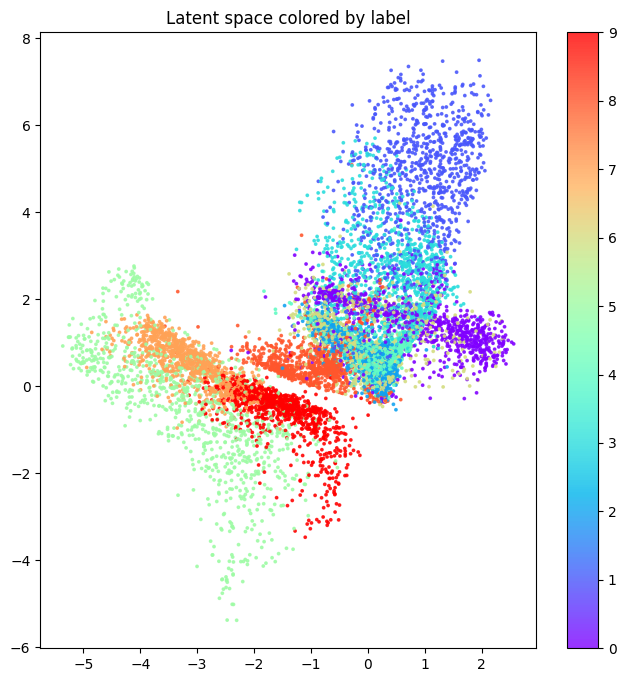

In [43]:
import matplotlib.pyplot as plt

figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.title("Latent space (black)")
plt.show()

# 按标签染色
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=labels,
    cmap="rainbow",
    alpha=0.8,
    s=3
)
plt.colorbar()
plt.title("Latent space colored by label")
plt.show()

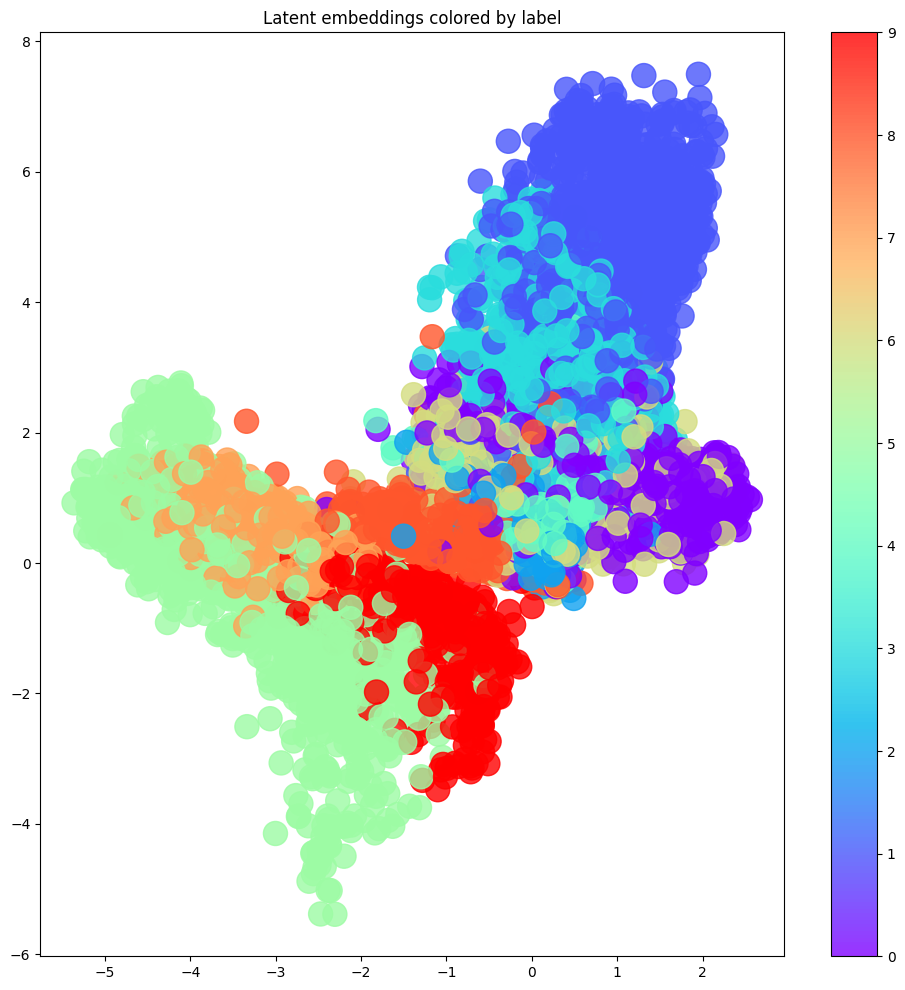

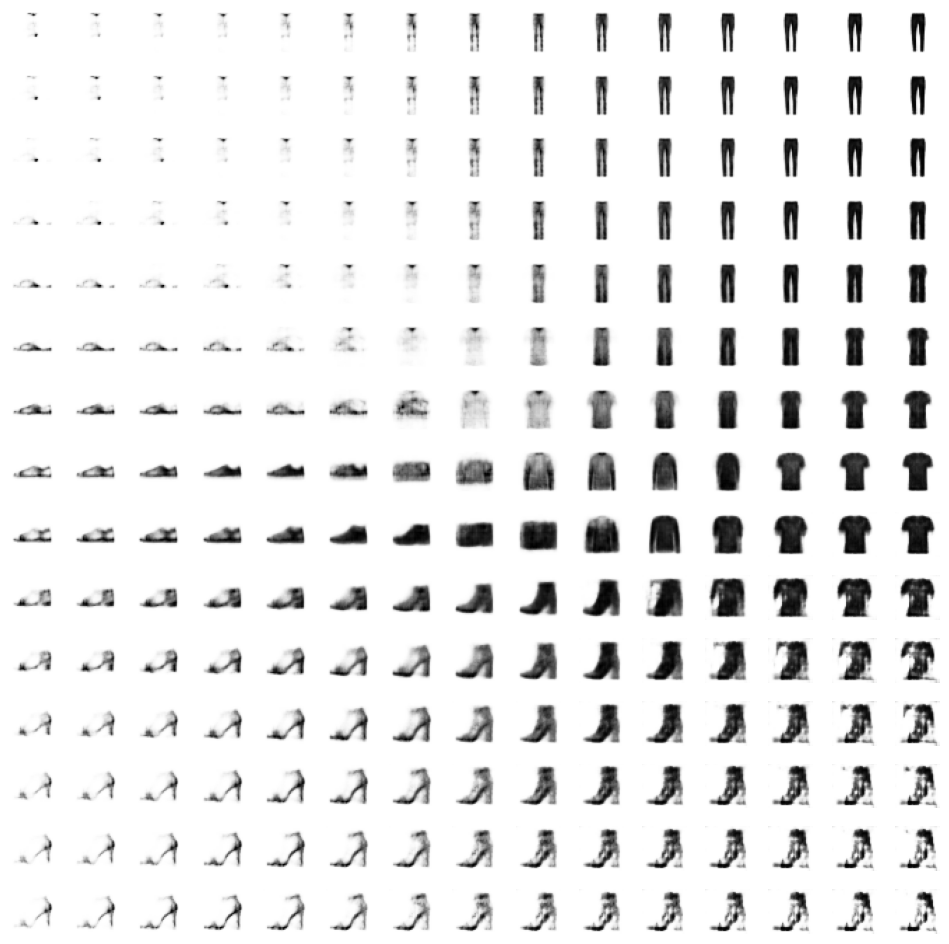

In [47]:
grid_size = 15
figsize = 12

# 绘制潜空间 embedding 的标签散点
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=labels,
    cmap="rainbow",
    alpha=0.8,
    s=300
)
plt.colorbar()
plt.title("Latent embeddings colored by label")
plt.show()

# 构建 latent space 网格
x = np.linspace(embeddings[:,0].min(), embeddings[:,0].max(), grid_size)
y = np.linspace(embeddings[:,1].max(), embeddings[:,1].min(), grid_size)
xv, yv = np.meshgrid(x, y)
grid = np.vstack([xv.flatten(), yv.flatten()]).T

grid_tensor = torch.tensor(grid, dtype=torch.float32).to(DEVICE)
with torch.no_grad():
    reconstructions = model.decoder(grid_tensor).cpu().numpy()  # [grid_size**2, 1, H, W]

# 显示网格生成图片
fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, 0], cmap="Greys")